# library

In [3]:
from os import listdir
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re

warnings.filterwarnings(action='ignore')

plt.style.use('ggplot') #ggplot스타일 사용
plt.rc('axes', unicode_minus=False)

# Data parse

In [4]:
# 자신의 경로를 넣으시면 됩니다
model_path = './modeling_folder'
data_file_path = './open data'

In [8]:
tr = pd.read_csv(
    os.path.join(data_file_path,'train.csv')
)
te = pd.read_csv(
    os.path.join(data_file_path,'test_x.csv')
)
submission = te[['index']]

# data preprocessing

In [9]:
# object 변수를 치환하자
ob_col_ls = tr.select_dtypes('object').columns.tolist()

le = LabelEncoder()
for col in ob_col_ls:
    le.fit(tr[col])
    tr[col] = le.transform(tr[col])
    te[col] = le.transform(te[col])

# Model training

In [10]:
tr.drop(columns = 'index',inplace = True)
te.drop(columns = 'index', inplace = True)

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.823866	training's binary_logloss: 0.518405	valid_1's auc: 0.765309	valid_1's binary_logloss: 0.558878
[100]	training's auc: 0.868459	training's binary_logloss: 0.480242	valid_1's auc: 0.763196	valid_1's binary_logloss: 0.560122
Early stopping, best iteration is:
[31]	training's auc: 0.802661	training's binary_logloss: 0.536706	valid_1's auc: 0.766879	valid_1's binary_logloss: 0.559394
Fold  1 AUC : 0.766879
Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.821221	training's binary_logloss: 0.51756	valid_1's auc: 0.761244	valid_1's binary_logloss: 0.564098
[100]	training's auc: 0.865638	training's binary_logloss: 0.47996	valid_1's auc: 0.759576	valid_1's binary_logloss: 0.565627
[150]	training's auc: 0.897802	training's binary_logloss: 0.44862	valid_1's auc: 0.758516	valid_1's binary_logloss: 0.566859
Early stopping, best iteration is:
[51]	training's auc: 0.822199	tra

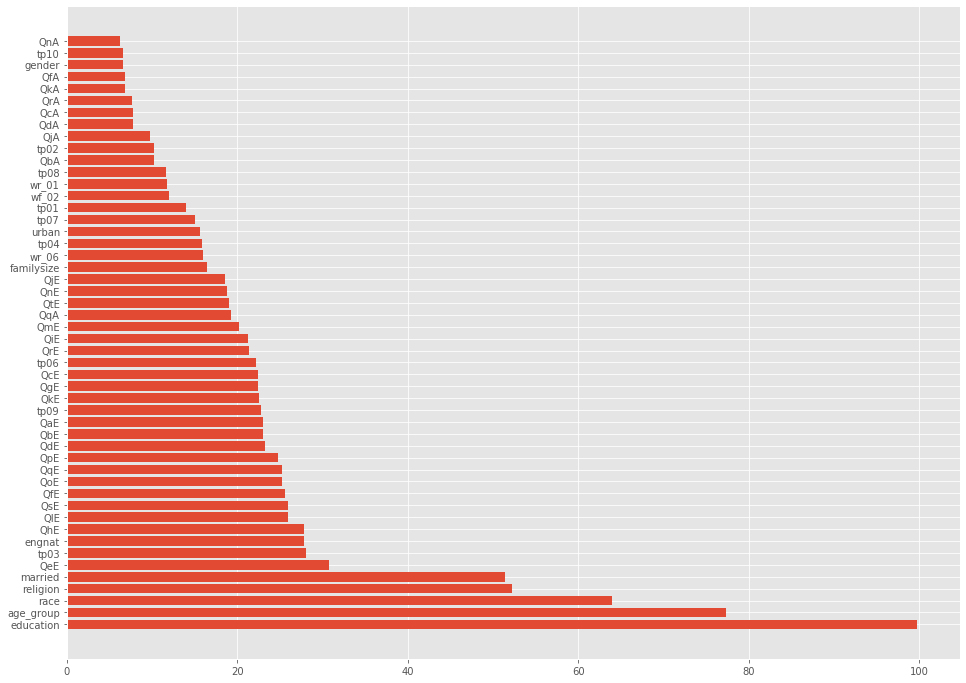

In [12]:
df = tr.copy()
    
# 검증셋을 추출합니다.
X_train, X_test, y_train, y_test = train_test_split(
                                df.drop(columns = 'voted'),df['voted'],
                                test_size = 0.2
                        )

# 여기선 5개의 fold로 나누어서 검증하겠습니다.
folds = KFold(n_splits=5, shuffle = True)

# 추론할 데이터에 대해서 빈값으로 먼저 매핑시켜줍니다.
oof_preds = np.zeros(X_train.shape[0])
test_preds = np.zeros(X_test.shape[0])
feature_importance = pd.DataFrame()

# 교차검증으로 학습시켜 제출전 검증셋으로 성능을 평가합니다.
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train,y_train)):
        
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    # 모델정의
    clf = lgb.LGBMClassifier(
        n_estimators=200,
        objective='binary',
        boosting_type='gbdt',
    )
    # 모델학습
    clf.fit(
        train_x, train_y,
        eval_set = [(train_x, train_y), (valid_x, valid_y)], 
        eval_metric='auc', 
        verbose= 50, 
        early_stopping_rounds=100,
    )
    # 검증셋 예측
    oof_preds[valid_idx] = clf.predict_proba(valid_x, best_iteration_ = clf.best_iteration_)[:,1]
    # 테스트셋 예측
    test_preds += clf.predict_proba(X_test, num_iteration = clf.best_iteration_)[:,1] / folds.n_splits 
    
    # 변수중요도 추출
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = X_train.columns
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance = pd.concat([feature_importance, fold_importance_df], axis=0)

    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))

# 변수중요도 top 50까지 뽑아서 시각화
ft = feature_importance.groupby('feature')['importance'].mean().reset_index()

ft2 = ft.sort_values('importance',ascending = False).iloc[:50]

feature_graph_df = feature_importance.sort_values('importance')
plt.figure(figsize = (16,12))
plt.barh(ft2['feature'],ft2['importance'])

# 결과 검증
final_score = roc_auc_score(y_test,test_preds)
print(f'최종성능 : {final_score}')

# Testset Inference

In [14]:
X_train = tr.drop(columns = 'voted')
y_train = tr['voted']
# 실제 예측할 값
test_preds = np.zeros(te.shape[0])
folds = KFold(n_splits=5, shuffle = True)

# 교차검증으로 학습시켜 제출전 검증셋으로 성능을 평가합니다.
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train,y_train)):
        
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    # 모델정의
    clf = lgb.LGBMClassifier(
        n_estimators=200,
        objective='binary',
        boosting_type='gbdt',
    )
    # 모델학습
    clf.fit(
        train_x, train_y,
        eval_set = [(train_x, train_y), (valid_x, valid_y)], 
        eval_metric='auc', 
        verbose= 50, 
        early_stopping_rounds=100,
    )
    # 실제 테스트셋 예측
    test_preds += clf.predict_proba(te, num_iteration = clf.best_iteration_)[:,1] / folds.n_splits 


Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.812264	training's binary_logloss: 0.52616	valid_1's auc: 0.766528	valid_1's binary_logloss: 0.555036
[100]	training's auc: 0.850117	training's binary_logloss: 0.494361	valid_1's auc: 0.766633	valid_1's binary_logloss: 0.555477
[150]	training's auc: 0.879089	training's binary_logloss: 0.466977	valid_1's auc: 0.766377	valid_1's binary_logloss: 0.555804
Early stopping, best iteration is:
[63]	training's auc: 0.822837	training's binary_logloss: 0.517294	valid_1's auc: 0.767562	valid_1's binary_logloss: 0.554547
Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.814247	training's binary_logloss: 0.524758	valid_1's auc: 0.766762	valid_1's binary_logloss: 0.558004
[100]	training's auc: 0.851169	training's binary_logloss: 0.493415	valid_1's auc: 0.764586	valid_1's binary_logloss: 0.559168
Early stopping, best iteration is:
[32]	training's auc: 0.79725	training's binary_logloss

# submission

In [ ]:
submission['voted'] = test_preds

submission.to_csv('자신의 경로.csv',index = False)